In [1]:
import numpy as np
import io, pandas as pd
import unicodedata
from gender_guesser.detector import Detector
detector = Detector(case_sensitive=False)

peersflatfile = pd.read_csv("../data/hollingsworth/tab/peersflatfile.tab", sep='\t', encoding='Windows-1252', low_memory=False)
peers = peersflatfile.drop_duplicates(subset=['Surname', 'First Names', 'B Day', 'B Month', 'B Year'])
len(peers)

28423

#these dupes should be dropped, with only the rwos with more information kept.

also, while we're here, lets also make nan people with surnames which arent strings, or which are less than two characters.

But, we only want _children_ of peers, not first generation peers. So, lets drop on 'Parent' and 'Parental Title'. First, lets see if theres any bad intersection of these two fields.

This immediately alerts us to the fact that something bad is happening. Why are more parents missing than parental title?

In [2]:
print(f'We are missing {len(peers[peers['Parent'].isnull()])} people with no "Parent" value in our raw peerage dataset from hollingsworth')
print(f'We are missing {len(peers[peers['Parental Title'].isnull()])} people with no "Parental Title" value in our raw peerage dataset from hollingsworth')

We are missing 1704 people with no "Parent" value in our raw peerage dataset from hollingsworth
We are missing 0 people with no "Parental Title" value in our raw peerage dataset from hollingsworth


Lets look at where some of these bad overlaps happen:

In [3]:
pattern = r'''(?ix)                  # i → ignore case, x → free-spacing
        (?:\bKing\b|\bQueen\b)       # royal styles (anywhere in the string)
    |                                # – OR –
        (?<=\d)                      # only immediately after a digit …
        (?:Bs|Ds|Ms|Vs|Cs|B|D|M|V|E) # … the peerage abbreviations
'''
peers = peers.copy()
peers.loc[:, "Extracted Parental Peerage"] = (
    peers.loc[:, "Parent"]
      .str.findall(pattern)          # list-of-matches or NaN
      .str.join(";")                 # ";".join(list)  – vectorised &
)                                    # NaN → stays NaN, not an error


In [4]:
mask = peers["Extracted Parental Peerage"].isin(["d", "e", "v"])
peers.loc[mask, "Extracted Parental Peerage"] = (
    peers.loc[mask, "Extracted Parental Peerage"].str.upper()
)
##############################################################################

# 2.  Map every peer-age code to its full style
import re

# 1.  Dictionary of FULL TITLES  ── keep all keys **UPPER-CASE**.
mapping = {
    "D":  "duke",        "DS": "duke",
    "M":  "marquess",    "MS": "marquess",
    "E":  "earl",        "CS": "earl",
    "V":  "viscount",    "VS": "viscount",
    "B":  "baron",       "BS": "baroness",
}

# 2.  Build a regex that prefers the two-letter codes first.
alts   = sorted(mapping, key=len, reverse=True)          # ["DS","VS",…,"D",…]
pattern = re.compile(rf"\b({'|'.join(alts)})\b", flags=re.I)  # case-insensitive

# 3.  Replace every code token inside ‘Extracted Parental Peerage’.
def _repl(m):
    return mapping[m.group(0).upper()]      # normalise to upper-case → look-up

peers.loc[:, "Extracted Parental Peerage"] = (
    peers["Extracted Parental Peerage"]
        .str.replace(pattern, _repl, regex=True)
)


In [5]:
peers.loc[:, 'Extracted Parental Peerage'] = peers['Extracted Parental Peerage'].replace('', np.nan)

astonishing; this is sensationally clean.

Now, in Hollingsworth we know that all these people are children of:

King/Queen, Duke, Duchess, Marquess, Marchioness, Earl, Countess, Viscount, Viscountess, Baron, Baroness.

In Lundy, we have people (and their children who are) who are:

Dukes and Duchesses, Marquesses and Marchionesses, Earls and Countesses, Barons and Baronesses (by letters patent), Barons and Baronesses (by writ), Life Peers, UK Law Lords, Scots Law Lords, Baronets

<Axes: xlabel='B Year'>

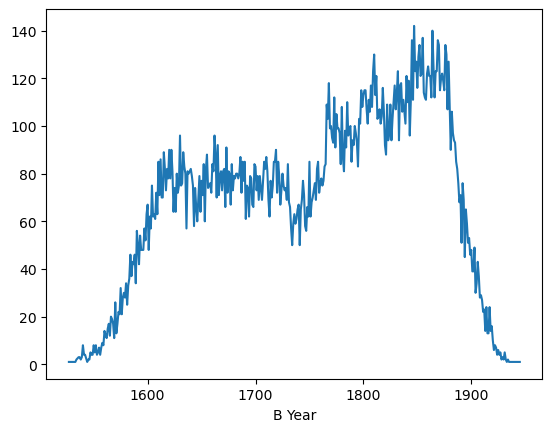

In [6]:
peers['B Year'].value_counts().sort_index().plot()

<Axes: xlabel='B Day'>

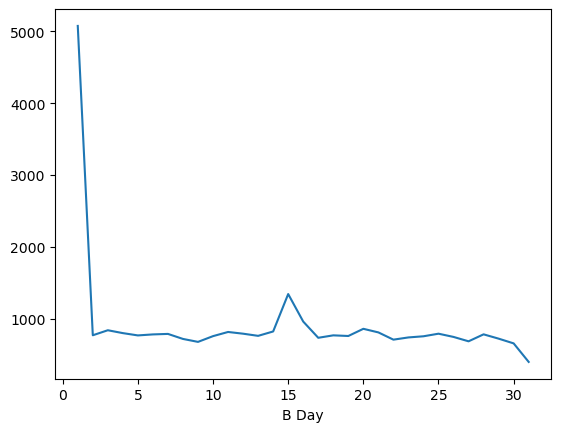

In [7]:
peers['B Day'].value_counts().sort_index().plot()

<Axes: xlabel='B Month'>

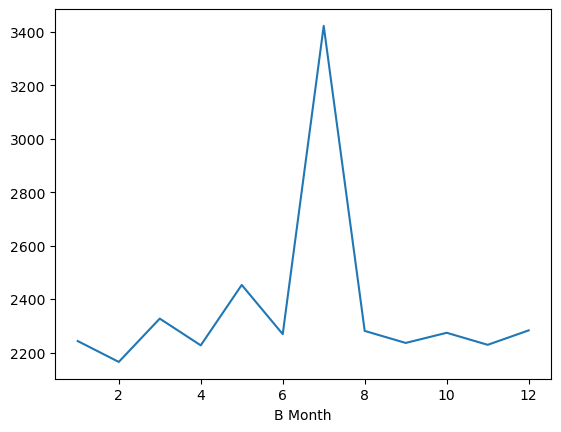

In [8]:
peers['B Month'].value_counts().sort_index().plot()

In [9]:
peers[['B Day', 'B Month', 'B Year']]

,B Day,B Month,B Year
0,12.0,8.0,1575.0
9,19.0,12.0,1599.0
11,16.0,9.0,1603.0
12,9.0,2.0,1605.0
22,28.0,7.0,1606.0
...,...,...,...
80703,14.0,12.0,1895.0
80705,25.0,4.0,1897.0
80707,31.0,3.0,1900.0
80709,20.0,12.0,1902.0


In [10]:
import datetime

def parse_historic(d):
    # expect d like "DD-MM-YYYY", but guard zeros or bad parses
    try:
        return datetime.datetime.strptime(d, "%d-%m-%Y")
    except Exception:
        return pd.NaT

# build your zero-filled strings as before:
days   = peers['B Day'].fillna(0).astype(int).astype(str).str.zfill(2)
months = peers['B Month'].fillna(0).astype(int).astype(str).str.zfill(2)
years  = peers['B Year'].fillna(0).astype(int).astype(str).str.zfill(4)
date_strings = days + '-' + months + '-' + years

# apply pure-Python parsing → object dtype
peers['born_datetime'] = date_strings.map(parse_historic)

In [11]:
peers[['B Day', 'B Month', 'B Year', 'born_datetime']]

,B Day,B Month,B Year,born_datetime
0,12.0,8.0,1575.0,1575-08-12 00:00:00
9,19.0,12.0,1599.0,1599-12-19 00:00:00
11,16.0,9.0,1603.0,1603-09-16 00:00:00
12,9.0,2.0,1605.0,1605-02-09 00:00:00
22,28.0,7.0,1606.0,1606-07-28 00:00:00
...,...,...,...,...
80703,14.0,12.0,1895.0,1895-12-14 00:00:00
80705,25.0,4.0,1897.0,1897-04-25 00:00:00
80707,31.0,3.0,1900.0,1900-03-31 00:00:00
80709,20.0,12.0,1902.0,1902-12-20 00:00:00


<Axes: xlabel='D Year'>

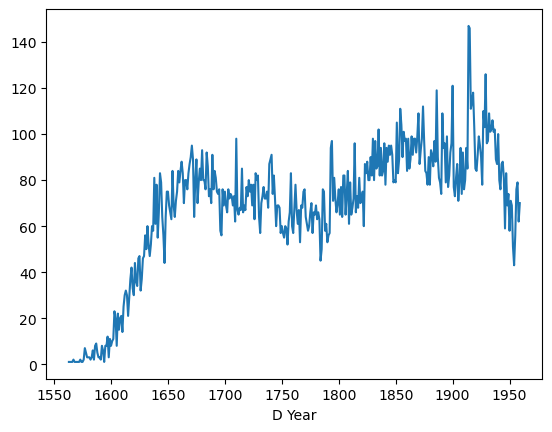

In [12]:
peers['D Year'].value_counts().sort_index().plot()

<Axes: xlabel='D Day'>

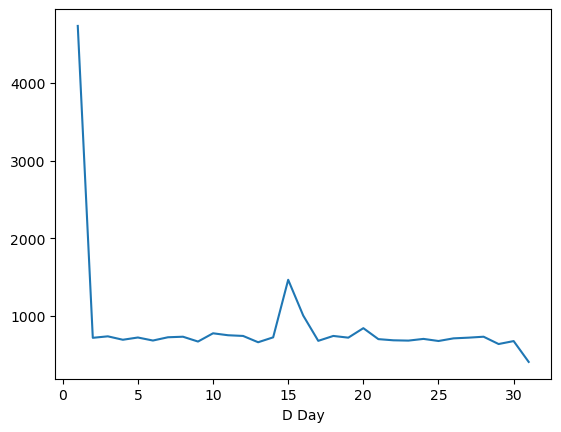

In [13]:
peers['D Day'].value_counts().sort_index().plot()

<Axes: xlabel='D Month'>

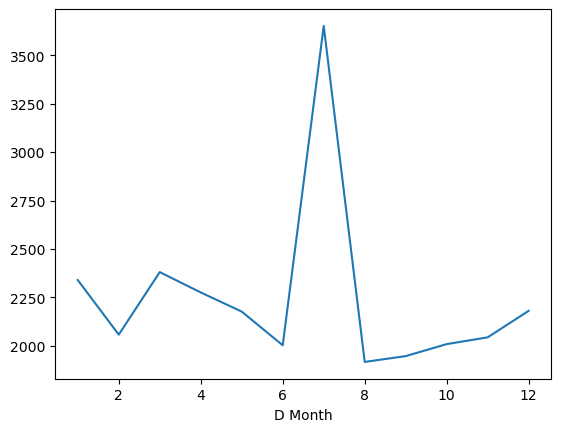

In [14]:
peers['D Month'].value_counts().sort_index().plot()

In [15]:
# build your zero-filled strings as before:
days   = peers['D Day'].fillna(0).astype(int).astype(str).str.zfill(2)
months = peers['D Month'].fillna(0).astype(int).astype(str).str.zfill(2)
years  = peers['D Year'].fillna(0).astype(int).astype(str).str.zfill(4)
date_strings = days + '-' + months + '-' + years

# apply pure-Python parsing → object dtype
peers['died_datetime'] = date_strings.map(parse_historic)

In [16]:
print(f'Min Birth Year: {peers['B Year'].min()}, Max Birth Year: {peers['B Year'].max()}')
print(f'Min Death Year: {peers['D Year'].min()}, Max Death Year: {peers['D Year'].max()}')

Min Birth Year: 1527.0, Max Birth Year: 1945.0
Min Death Year: 1563.0, Max Death Year: 1959.0


In [17]:
def clean_string(s: str) -> str:
    """
    1. Remove parenthesized content (non-greedy).
    2. Normalize to NFKD and drop diacritical marks.
    3. Replace any dash-like run (hyphen, en-dash, em-dash) with a single ASCII space.
    4. Remove everything except ASCII letters (A–Z, a–z) and spaces.
    5. Collapse multiple spaces to one, then strip ends.
    """
    # 1) Strip "(…)" and contents
    s = re.sub(r'\(.*?\)', '', s)
    # 2) Decompose accents
    s = unicodedata.normalize('NFKD', s)
    # 3) Dashes → space
    s = re.sub(r'[-–—]+', ' ', s)
    # 4) Keep only letters and spaces
    s = re.sub(r'[^A-Za-z ]+', '', s)
    # 5) Collapse spaces and trim
    s = re.sub(r'\s{2,}', ' ', s).strip()
    return s




honorifics = [
    'Mr', 'Mrs', 'Ms', 'Miss', 'Dr', 'Prof',
    'Sir', 'Dame',
    'Lord', 'Lady', 'Baron', 'Baroness',
    'Viscount', 'Viscountess', 'Earl',
    'Marquess', 'Marquis', 'Duke', 'Duchess',
    'Count', 'Countess',
    'Rev', 'Reverend', 'Hon', 'Honorable', 'Rt Hon', 'Right Honourable',
    'Major', 'Colonel', 'Capt', 'Captain',
    'Lt', 'Lt Col', 'Lt-Col', 'Lt\\.', 'Brigadier', 'Brigadier-General',
    'General', 'Field Marshal', 'Wing Commander', 'Squadron Leader',
    'Saint', 'St'
]

escaped = [re.escape(h) for h in honorifics]
pattern = re.compile(
    r'^(?:' + r'|'.join(escaped) + r')\.?\s+', 
    flags=re.IGNORECASE
)

def strip_honorifics(name: str) -> str:
    """Remove any leading honorific/rank from a fullname."""
    if pd.isna(name):
        return name
    return pattern.sub('', name).strip()

peers['First Names_clean'] = peers['First Names'].apply(strip_honorifics)
peers['First Names_clean'] = peers['First Names_clean'].str.upper()
peers['First Forename'] = peers['First Names_clean'].str.split(' ').str[0]

peers['Surname_clean'] = peers['Surname'].apply(strip_honorifics)
peers['Surname_clean'] = peers['Surname_clean'].str.upper()
peers['Last Surname'] = peers['Surname_clean'].str.split(' ').str[-1]
peers['Full_Name'] = peers['First Names_clean'] + ' ' + peers['Surname_clean']



# Apply to the Series and store result in a new column
peers['Full_Name'] = peers['Full_Name'].apply(clean_string)
peers['First Forename'] = peers['First Forename'].apply(clean_string)
peers['Last Surname'] = peers['Last Surname'].apply(clean_string)


In [18]:
# Lets now make it as equivilent as possible to lundy:
peers = peers.rename({'Full_Name': 'Full_Name_h'}, axis=1)
peers = peers.rename({'First Forename': 'First Forename_h'}, axis=1)
peers = peers.rename({'Last Surname': 'Last Surname_h'}, axis=1)
peers = peers.rename({'peers_Sex': 'Gender_h'}, axis=1)
peers = peers.rename({'B Day': 'born_day_h'}, axis=1)
peers = peers.rename({'B Month': 'born_month_h'}, axis=1)
peers = peers.rename({'B Year': 'born_year_h'}, axis=1)
peers = peers.rename({'B Acc': 'born_accuracy_h'}, axis=1)
peers = peers.rename({'D Day': 'died_day_h'}, axis=1)
peers = peers.rename({'D Month': 'died_month_h'}, axis=1)
peers = peers.rename({'D Year': 'died_year_h'}, axis=1)
peers = peers.rename({'D Acc': 'died_accuracy_h'}, axis=1)
peers = peers.rename({'born_datetime': 'born_datetime_h'}, axis=1)
peers = peers.rename({'died_datetime': 'died_datetime_h'}, axis=1)
peers = peers.rename({'Extracted Parental Peerage': 'Extracted Parental Peerage_h'}, axis=1)

In [19]:
peers = peers[['Full_Name_h',
               'First Forename_h',
               'Last Surname_h',
               'Gender_h',
               'born_day_h',
               'born_month_h',
               'born_year_h',
               'born_accuracy_h',
               'died_day_h',
               'died_month_h',
               'died_year_h',
               'died_accuracy_h',
               'born_datetime_h',
               'died_datetime_h',
               'Extracted Parental Peerage_h']]

In [20]:
peers['First Forename_h'].value_counts()

First Forename_h
JOHN         1517
WILLIAM      1399
MARY         1300
CHARLES      1081
ELIZABETH    1061
             ... 
CELIA           1
SIBELLA         1
IABELLA         1
ION             1
THURSTAN        1
Name: count, Length: 1639, dtype: int64

In [21]:
peers[peers['First Forename_h']=='']

,Full_Name_h,First Forename_h,Last Surname_h,Gender_h,born_day_h,born_month_h,born_year_h,born_accuracy_h,died_day_h,died_month_h,died_year_h,died_accuracy_h,born_datetime_h,died_datetime_h,Extracted Parental Peerage_h
521,NEVILL,,NEVILL,M,22.0,11.0,1627.0,6,1.0,7.0,1637.0,3,1627-11-22 00:00:00,1637-07-01 00:00:00,baron
537,NEVILL,,NEVILL,F,20.0,11.0,1723.0,y,1.0,12.0,1723.0,y,1723-11-20 00:00:00,1723-12-01 00:00:00,baron
997,AIREY,,AIREY,M,28.0,7.0,1840.0,0,18.0,9.0,1840.0,x,1840-07-28 00:00:00,1840-09-18 00:00:00,baron
1121,OGILVY,,OGILVY,M,21.0,9.0,1823.0,y,28.0,9.0,1823.0,2,1823-09-21 00:00:00,1823-09-28 00:00:00,earl
1193,MONCK,,MONCK,M,1.0,11.0,1673.0,8,1.0,11.0,1673.0,8,1673-11-01 00:00:00,1673-11-01 00:00:00,duke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69373,STURT,,STURT,M,30.0,4.0,1903.0,y,13.0,5.0,1903.0,y,1903-04-30 00:00:00,1903-05-13 00:00:00,baron
72751,RICE,,RICE,M,21.0,1.0,1870.0,y,21.0,1.0,1870.0,y,1870-01-21 00:00:00,1870-01-21 00:00:00,baron
72927,BASIL TEMPLE HAMILTON TEMPLE BLACKWOOD,,BLACKWOOD,M,4.0,11.0,1870.0,y,3.0,7.0,1917.0,y,1870-11-04 00:00:00,1917-07-03 00:00:00,marquess
73151,MONTGOMERIE,,MONTGOMERIE,M,25.0,12.0,1878.0,y,12.0,1.0,1879.0,y,1878-12-25 00:00:00,1879-01-12 00:00:00,earl


In [22]:
peers.to_csv('../data/hollingsworth/wrangled/peers.csv')